Database 4: Lens Models
=======================

This tutorial builds on the tutorial `a1_samples`, where we use the aggregator to load models from a non-linear
search and visualize and interpret results.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
from astropy import cosmology as cosmo

%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import autolens as al
import autolens.plot as aplt
import matplotlib.pyplot as plt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`
/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


First, set up the aggregator as we did in the previous tutorial.

In [2]:
# from autofit.database.aggregator import Aggregator
# database_file = path.join("output", "database", "database.sqlite")
# agg = Aggregator.from_database(path.join(database_file))
agg = af.Aggregator(directory=path.join("output", "database"))

Aggregator loading search_outputs... could take some time.

 A total of 3 search_outputs and results were found.


Next, lets create a list of instances of the maximum log likelihood models of each fit.

In [3]:
ml_instances = [samps.max_log_likelihood_instance for samps in agg.values("samples")]

A model instance contains a list of `Galaxy` instances, which is what we are using to passing to functions in 
PyAutoLens. Lets create the maximum log likelihood tracer of every fit.

In [4]:
ml_tracers = [
    al.Tracer.from_galaxies(galaxies=instance.galaxies) for instance in ml_instances
]

print("Maximum Log Likelihood Tracers: \n")
print(ml_tracers, "\n")
print("Total Tracers = ", len(ml_tracers))

Maximum Log Likelihood Tracers: 

[<autolens.lens.ray_tracing.Tracer object at 0x7f10314243d0>, <autolens.lens.ray_tracing.Tracer object at 0x7f103142fac0>, <autolens.lens.ray_tracing.Tracer object at 0x7f103142fdc0>] 

Total Tracers =  3


Now lets plot their convergences, using a grid of 100 x 100 pixels (noting that this isn't` necessarily the grid used
to fit the data in the search itself).

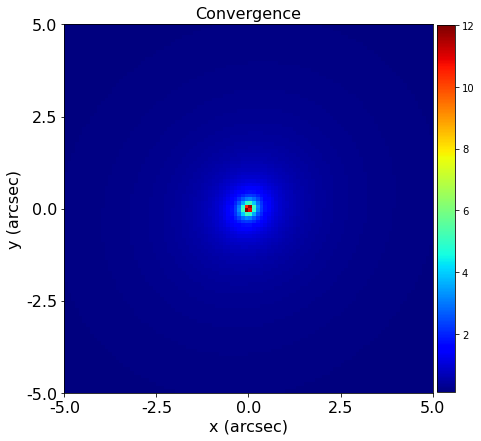

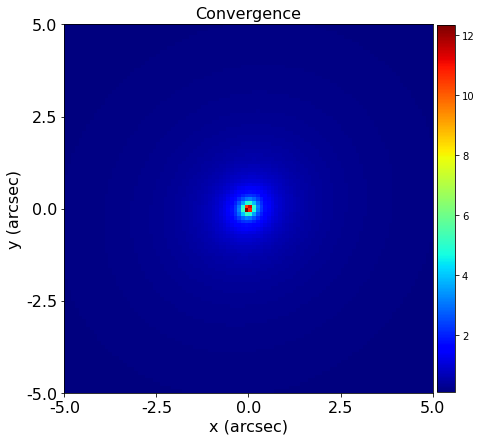

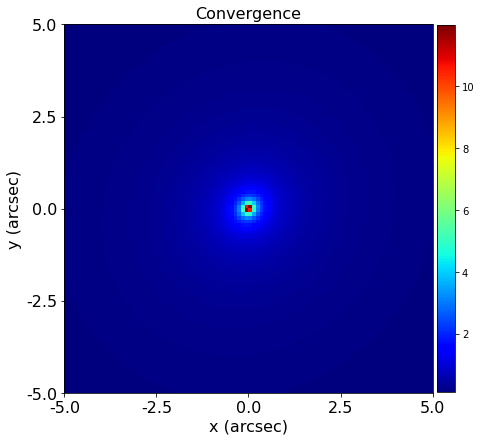

In [5]:
grid = al.Grid2D.uniform(shape_native=(100, 100), pixel_scales=0.1)

for tracer in ml_tracers:
    tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
    tracer_plotter.figures_2d(convergence=True)

Okay, so we can make a list of tracers and plot their convergences. However, we'll run into the same problem using 
lists which we discussed in the previous tutorial. If we had fitted hundreds of images we`d have hundreds of tracers, 
overloading the memory on our laptop.

We can again avoid using lists for any objects that could potentially be memory intensive, using generators.

In [6]:


def make_tracer_generator(agg_obj):

    samples = agg_obj.samples

    return al.Tracer.from_galaxies(
        galaxies=samples.max_log_likelihood_instance.galaxies
    )


We `map` the function above using our aggregator to create a tracer generator.

In [7]:
tracer_gen = agg.map(func=make_tracer_generator)

We can now iterate over our tracer generator to make the plots we desire.

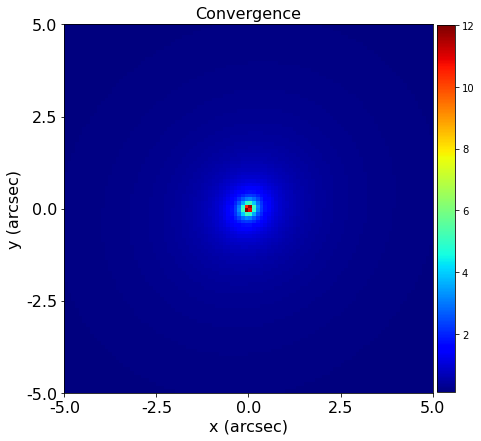

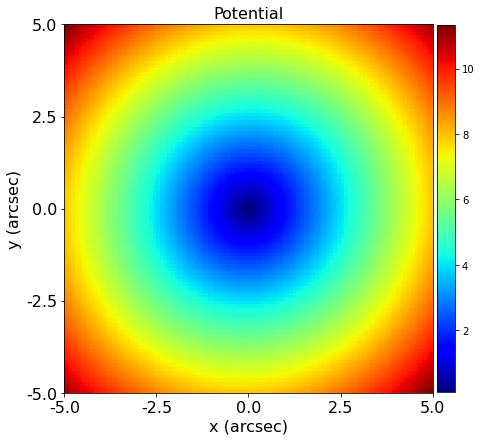

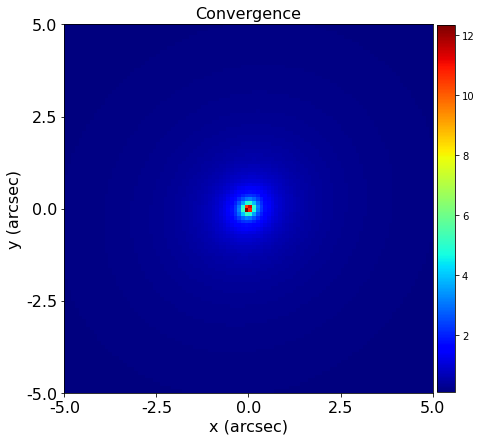

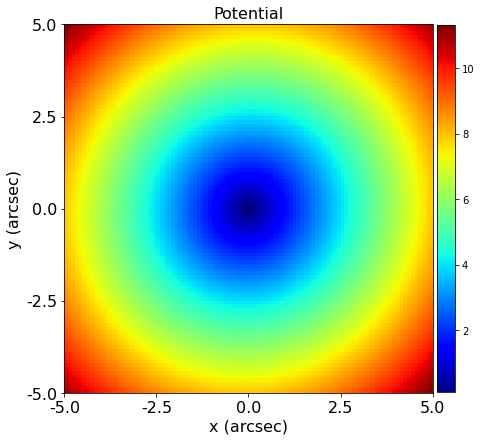

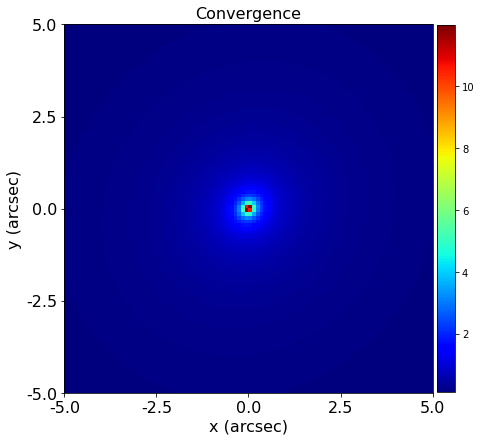

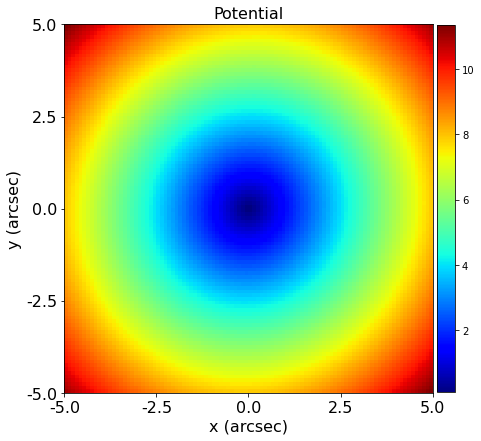

In [8]:
grid = al.Grid2D.uniform(shape_native=(100, 100), pixel_scales=0.1)

for tracer in tracer_gen:

    tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
    tracer_plotter.figures_2d(convergence=True, potential=True)

Its cumbersome to always have to define a `make_tracer_generator` function to make a tracer generator, given that 
you`ll probably do the exact same thing in every Jupyter Notebook you ever write!

PyAutoLens`s aggregator module (imported as `agg`) has convenience methods to save you time and make your notebooks
cleaner.

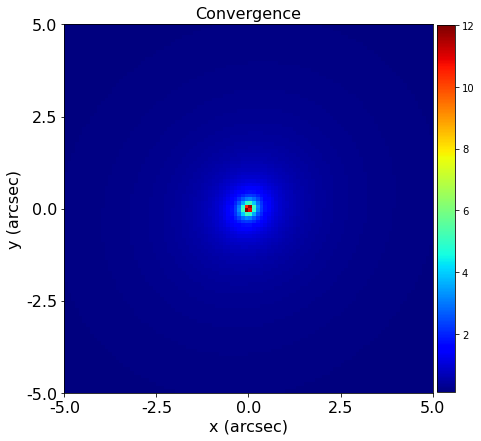

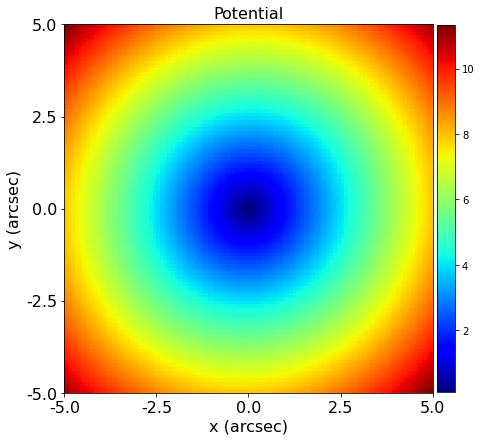

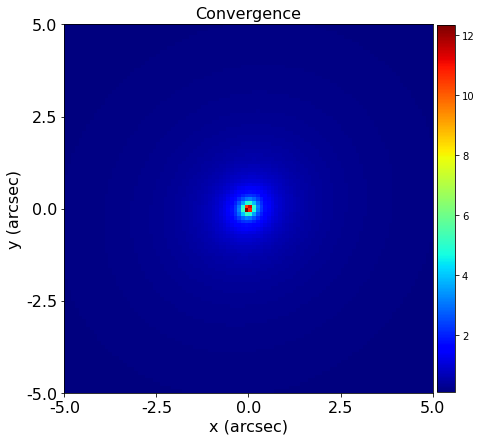

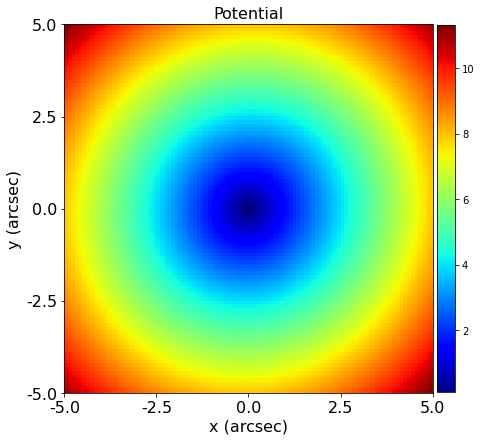

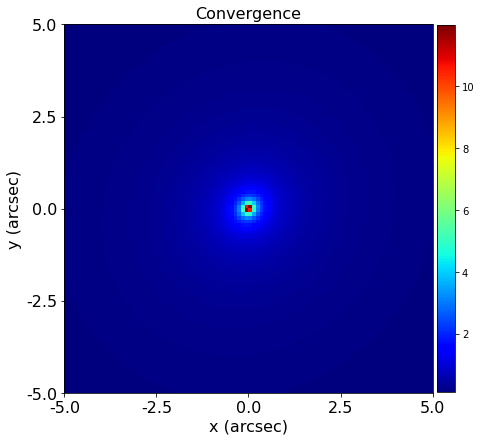

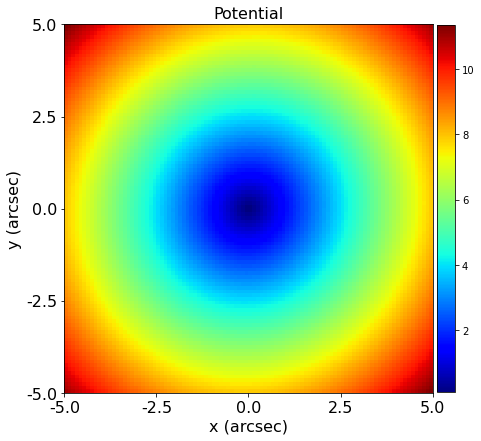

In [9]:
tracer_gen = al.agg.Tracer(aggregator=agg)

for tracer in tracer_gen:

    tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
    tracer_plotter.figures_2d(convergence=True, potential=True)

Because instances are just lists of galaxies we can directly extract attributes of the `Galaxy` class. Lets print 
the Einstein mass of each of our most-likely lens galaxies.

The model instance uses the model defined by a pipeline. In this pipeline, we called the lens galaxy `lens`.

For illustration, lets do this with a list first:

In [10]:
print("Maximum Log Likelihood Lens Einstein Masses:")

for instance in ml_instances:

    einstein_mass = instance.galaxies.lens.einstein_mass_angular_from_grid(grid=grid)

    print("Einstein Mass (angular units) = ", einstein_mass)

    critical_surface_density = al.util.cosmology.critical_surface_density_between_redshifts_from(
        redshift_0=instance.galaxies.lens.redshift,
        redshift_1=instance.galaxies.source.redshift,
        cosmology=cosmo.Planck15,
    )

    einstein_mass_kpc = einstein_mass * critical_surface_density

    print("Einstein Mass (kpc) = ", einstein_mass_kpc)
    print("Einstein Mass (kpc) = ", "{:.4e}".format(einstein_mass_kpc))

    print(einstein_mass)

print()

Maximum Log Likelihood Lens Einstein Masses:
Einstein Mass (angular units) =  7.956827282022385
Einstein Mass (kpc) =  944492043684.1384
Einstein Mass (kpc) =  9.4449e+11
7.956827282022385
Einstein Mass (angular units) =  7.942840384801669
Einstein Mass (kpc) =  942831769724.109
Einstein Mass (kpc) =  9.4283e+11
7.942840384801669
Einstein Mass (angular units) =  7.971573864471138
Einstein Mass (kpc) =  946242493869.9617
Einstein Mass (kpc) =  9.4624e+11
7.971573864471138



Now lets use a generator.

In [11]:


def print_max_log_likelihood_mass(agg_obj):

    samples = agg_obj.samples

    einstein_mass = samples.instance.galaxies.lens.einstein_mass_angular_from_grid(
        grid=grid
    )

    print("Einstein Mass (angular units) = ", einstein_mass)

    critical_surface_density = al.util.cosmology.critical_surface_density_between_redshifts_from(
        redshift_0=samples.instance.galaxies.lens.redshift,
        redshift_1=samples.instance.galaxies.source.redshift,
        cosmology=cosmo.Planck15,
    )

    einstein_mass_kpc = einstein_mass * critical_surface_density

    print("Einstein Mass (kpc) = ", einstein_mass_kpc)
    print("Einstein Mass (kpc) = ", "{:.4e}".format(einstein_mass_kpc))


print("Maximum Log Likelihood Lens Einstein Masses:")
agg.map(func=print_max_log_likelihood_mass)

Maximum Log Likelihood Lens Einstein Masses:


Lets next do something a bit more ambitious. Lets create a plot of the einstein_radius vs axis_ratio of each 
`EllIsothermal` `MassProfile`.

These plots don't use anything too memory intensive (like a tracer) so we are fine to go back to lists for this.

[1.5938014065752786, 1.5924463495158379, 1.5953126885375088]
[0.9002688042110568, 0.8993871745084231, 0.8995094287309707]


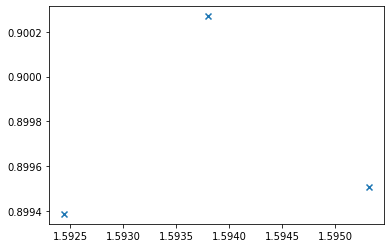

In [12]:
mp_instances = [samps.median_pdf_instance for samps in agg.values("samples")]
mp_einstein_radii = [
    instance.galaxies.lens.mass.einstein_radius for instance in mp_instances
]
mp_elliptical_comps = [
    instance.galaxies.lens.mass.elliptical_comps for instance in mp_instances
]

mp_axis_ratios = [
    al.convert.axis_ratio_from(elliptical_comps=ell) for ell in mp_elliptical_comps
]

print(mp_einstein_radii)
print(mp_axis_ratios)

plt.scatter(mp_einstein_radii, mp_axis_ratios, marker="x")
plt.show()

Now lets also include error bars at 3 sigma confidence.

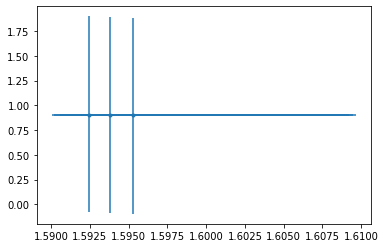

In [13]:
ue3_instances = [
    samps.error_instance_at_upper_sigma(sigma=3.0) for samps in agg.values("samples")
]
le3_instances = [
    samps.error_instance_at_lower_sigma(sigma=3.0) for samps in agg.values("samples")
]

ue3_einstein_radii = [
    instance.galaxies.lens.mass.einstein_radius for instance in ue3_instances
]
le3_einstein_radii = [
    instance.galaxies.lens.mass.einstein_radius for instance in le3_instances
]
ue3_elliptical_comps = [
    instance.galaxies.lens.mass.elliptical_comps for instance in ue3_instances
]
le3_elliptical_comps = [
    instance.galaxies.lens.mass.elliptical_comps for instance in le3_instances
]

ue3_axis_ratios = [
    al.convert.axis_ratio_from(elliptical_comps=ell) for ell in ue3_elliptical_comps
]
le3_axis_ratios = [
    al.convert.axis_ratio_from(elliptical_comps=ell) for ell in le3_elliptical_comps
]

plt.errorbar(
    x=mp_einstein_radii,
    y=mp_axis_ratios,
    marker=".",
    linestyle="",
    xerr=[le3_einstein_radii, ue3_einstein_radii],
    yerr=[le3_axis_ratios, ue3_axis_ratios],
)
plt.show()

In the runner, we used the pickle_files input to search.run() to pass a .pickle file from the dataset folder to 
the database. 

Our strong lens dataset was created via a simulator script, so we passed the `Tracer` used to simulate the strong
lens, which was written as a .pickle file called `true_tracer.pickle` to the search to make it accessible in the 
database. This will allow us to directly compare the inferred lens model to the `truth`. 

In [14]:
# true_tracers = [true_tracer for true_tracer in agg.values("true_tracer")]

print("Parameters used to simulate the lens dataset:")
# print(true_tracers)

Parameters used to simulate the lens dataset:


Finish.